In [10]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
import nltk
##nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [11]:
data_dep = pd.read_csv(os.getcwd() + "/datasets/depressTweets")
data_happy = pd.read_csv(os.getcwd() + "/datasets/happyTweets")

In [208]:
print(data_dep.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3045 entries, 0 to 3282
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            3045 non-null   object
 1   verified         3045 non-null   object
 2   followers_count  3045 non-null   object
 3   friends_count    3045 non-null   object
 4   Sentiment        3045 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 142.7+ KB
None


In [207]:
print(data_happy.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2318 entries, 0 to 2328
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            2318 non-null   object
 1   verified         2318 non-null   object
 2   followers_count  2318 non-null   object
 3   friends_count    2318 non-null   object
 4   Sentiment        2318 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 108.7+ KB
None


In [14]:
data_dep.drop_duplicates(keep="first",inplace=True)
data_happy.drop_duplicates(keep="first",inplace=True)
data_dep.drop(['description','screen_name'],axis=1,inplace=True)
data_happy.drop(['description','screen_name'],axis=1,inplace=True)

In [209]:
print(data_dep.shape)
print(data_happy.shape)

(3045, 5)
(2318, 5)


In [210]:
data_dep['Sentiment'] = 0
data_happy['Sentiment'] = 1
dataset = pd.concat([data_happy,data_dep.iloc[:data_happy.shape[0] + 50,:]], axis=0)
dataset.reset_index(drop=True,inplace=True)
dataset = dataset.drop(223,axis=0)
dataset = dataset.drop(2330,axis=0)
dataset = dataset.drop(2332,axis=0)
dataset.reset_index(drop=True,inplace=True)

In [211]:
dataset['Sentiment'].value_counts()

0    2366
1    2317
Name: Sentiment, dtype: int64

In [91]:
ps = PorterStemmer()
corpus = []
for i in range(0, dataset.shape[0]):
    review = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|[^\w\s{}]"," ",dataset['tweet'][i]).lower().split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [92]:
X_values = dataset.iloc[:,1:4]
X_values["followers_count"] = X_values["followers_count"].astype(str).astype(int)
X_values["friends_count"] = X_values["friends_count"].astype(str).astype(int)

In [93]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
X_values['verified'] = encoder.fit_transform(X_values['verified'])

In [94]:
pos_words = ''
for i in range(0,2318):
    pos_words += " ".join(corpus[i].split())+" "

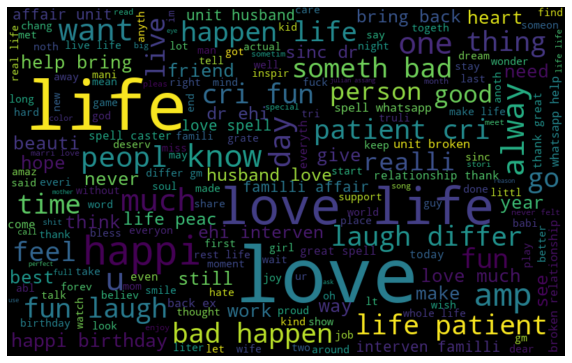

In [95]:
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [96]:
depress_words = ''
for i in range(2318,len(corpus)):
    depress_words += " ".join(corpus[i].split())+" "

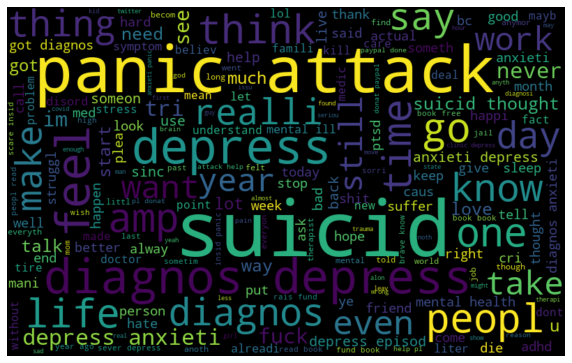

In [97]:
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(depress_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [190]:
v = CountVectorizer(stop_words='english',min_df=5,max_df=0.90) 
bow = v.fit_transform(corpus)

In [198]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(with_centering=False)
X_values_scaled = scaler.fit_transform(X_values)

In [199]:
from scipy.sparse import hstack 
X = hstack([X_values_scaled, bow])       
y = dataset['Sentiment']

# Modelling and Tuning

In [200]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

## SVM 

In [201]:
svc = SVC(kernel="linear", random_state=42)

scores = cross_validate(svc,X,y, scoring=scoring,cv=kf)
print("Average Test Accuracy: " + str(scores['test_accuracy'].mean()) + "\n" 
      + "Average Test Precison: " + str(scores['test_precision'].mean()) + "\n" 
      + "Average Test Recall: " + str(scores['test_recall'].mean()) + "\n"
      + "Average Test f1_score: " + str(scores['test_f1_score'].mean()) + "\n")

Average Test Accuracy: 0.9952539658896254
Average Test Precison: 0.9948173931694022
Average Test Recall: 0.9957874203874881
Average Test f1_score: 0.99529401261119



## NAIVE BAYES 

### Gaussian Naive Bayes

In [202]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
scores = cross_validate(nb,X.toarray(),y, scoring=scoring,cv=kf)
print("Average Test Accuracy: " + str(scores['test_accuracy'].mean()) + "\n" 
      + "Average Test Precison: " + str(scores['test_precision'].mean()) + "\n" 
      + "Average Test Recall: " + str(scores['test_recall'].mean()) + "\n"
      + "Average Test f1_score: " + str(scores['test_f1_score'].mean()) + "\n")

Average Test Accuracy: 0.8676919639532287
Average Test Precison: 0.8912833072445959
Average Test Recall: 0.8385258691990692
Average Test f1_score: 0.8638483389749055



### Multinomial Naive Bayes

In [203]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB(alpha=0.01)
scores = cross_validate(nb,X,y, scoring=scoring,cv=kf)
print("Average Test Accuracy: " + str(scores['test_accuracy'].mean()) + "\n" 
      + "Average Test Precison: " + str(scores['test_precision'].mean()) + "\n" 
      + "Average Test Recall: " + str(scores['test_recall'].mean()) + "\n"
      + "Average Test f1_score: " + str(scores['test_f1_score'].mean()) + "\n")

Average Test Accuracy: 0.8801975497132644
Average Test Precison: 0.9814845526146965
Average Test Recall: 0.7756058837938945
Average Test f1_score: 0.8661606371004893



## XG Boost

In [204]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

scores = cross_validate(model,X,y,scoring=scoring,cv=kf)

print("Average Test Accuracy: " + str(scores['test_accuracy'].mean()) + "\n"
      + "Average Test Precison: " + str(scores['test_precision'].mean()) + "\n" 
      + "Average Test Recall: " + str(scores['test_recall'].mean()) + "\n"
      + "Average Test f1_score: " + str(scores['test_f1_score'].mean()) + "\n")

Average Test Accuracy: 0.9954671557309898
Average Test Precison: 0.9974339382203764
Average Test Recall: 0.9935890602493853
Average Test f1_score: 0.9954990069120967

